In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from tensorboardX import SummaryWriter

import os
from utils import tools


# import FlowNetC
from networks import FlowNetC

from PIL import Image
import numpy as np
import pandas as pd

# import flowlib

from PIL import Image

import tqdm
import cv2
import csv
import time

In [206]:
cap = cv2.VideoCapture('data/caolin_foot_trial1-4.mp4')
name = 'caolin'

framerate = cap.get(5)
total_image = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'The oringinal framerate is {cap.get(5)} with frame resolution of: {cap.get(3), cap.get(4)}')
print(f'The total number of frame in this video is {total_image}')

The oringinal framerate is 25.0 with frame resolution of: (768.0, 576.0)
The total number of frame in this video is 17155


In [207]:
count = 1
while(cap.isOpened()):
    frameID = cap.get(1) # get the current frame number
    ret, frame = cap.read()
    
    if(ret != True):
        print(f'We\'ve gotten {int(frameID/5)+1} frames from this video.')
        break
    if (frameID % int(framerate/5) == 0):
        frame = frame[64:, 170:600 , :]
        filename = 'Train_1/'+ name + "_frame%04d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

We've gotten 3432 frames from this video.


## Building Dataset

In [13]:
image_files = dataset.image_files

In [14]:
class MyDataset:
    
    def __init__(self, num_train_img = 3400, base_dir = '/home/projectx/Documents/GitHub repos/VINET_modification/', sequence = 'Train_1/'):  # base_dir(image) and sequence(lstm) are directories
        self.base_dir = base_dir
        self.sequence = sequence
        self.base_path_img = self.base_dir + self.sequence
        
        self.image_files = os.listdir(self.base_path_img)
        self.image_files.sort()
        self.image_files = self.image_files[0:num_train_img]
        
        ## Omega.7 and load cells
        self.input_lstm = self.read_OMEGA7_LC()
        
        
        self.imu_seq_len = 20
    
    def read_OMEGA7_LC(self, path='data/result_1.csv'):
        # read csv data
        df = pd.read_csv(path,header = None)
        df = df[:874300]
        
        # take moving average of every 10 data points
        new_df = df.groupby(df.index//10).mean()
        array_input = np.array(new_df)
        input_lstm  = Variable(torch.from_numpy(array_input).type(torch.FloatTensor))
        input_lstm = input_lstm[:80000,:]
        
        # reshape to (num_dataset, sequence_length, feature_size)
        input_lstm = input_lstm.view(-1,20,11)
        
        return np.array(input_lstm)
    
    
    def get_input_lstm(self):
        return self.input_lstm
    
    def __len__(self):
        return len(self.image_files)
    
    def load_img_bat(self, idx, batch):
        batch_x = []
        batch_input_lstm = []
        for i in range(batch):
            x_data_np_1 = np.array(Image.open(self.base_path_img + self.image_files[idx + i]))
            x_data_np_2 = np.array(Image.open(self.base_path_img + self.image_files[idx+1 + i]))
            x_data_np_1 = x_data_np_1.reshape(3,512,430)
            x_data_np_2 = x_data_np_2.reshape(3,512,430)

#             ## 3 channels
#             x_data_np_1 = np.array([x_data_np_1, x_data_np_1, x_data_np_1])
#             x_data_np_2 = np.array([x_data_np_2, x_data_np_2, x_data_np_2])

            X = np.array([x_data_np_1, x_data_np_2])
            batch_x.append(X)
        
#           self.input_lstm of size: (num_dataset, sequence_length, feature_size)
            tmp = np.array(self.input_lstm[idx + i])
            batch_input_lstm.append(tmp)
            
        
        batch_x = np.array(batch_x)
        batch_input_lstm = np.array(batch_input_lstm)
        
        X = Variable(torch.from_numpy(batch_x).type(torch.FloatTensor).cuda())    
        X2 = Variable(torch.from_numpy(batch_input_lstm).type(torch.FloatTensor).cuda())    
        
        Y = X2[:,:,-3:]
        
     
        return X, X2 , Y

In [15]:
dataset = MyDataset()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
input_lstm = dataset.get_input_lstm()

In [73]:
X, X2 , Y = dataset.load_img_bat(0,1)

In [74]:
X.size(), X2.size() , Y.size() 

(torch.Size([1, 2, 3, 512, 430]),
 torch.Size([1, 20, 11]),
 torch.Size([1, 20, 3]))

In [20]:
X = X.view(1,-1,  512, 430)
X.size()

torch.Size([1, 6, 512, 430])

In [63]:
output = flownet_c(X)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [64]:
output.size()

torch.Size([1, 1024, 8, 7])

In [62]:
flownet_c = FlowNetC.FlowNetC(batchNorm=False)
checkpoint = None
checkpoint_pytorch = 'FlowNet2-C_checkpoint.pth.tar'
#checkpoint_pytorch = '/notebooks/data/model/FlowNet2-SD_checkpoint.pth.tar'
if os.path.isfile(checkpoint_pytorch):
    checkpoint = torch.load(checkpoint_pytorch,\
                        map_location=lambda storage, loc: storage.cuda(0))
    pop_list = ["deconv5.0.weight", "deconv5.0.bias", "deconv4.0.weight", "deconv4.0.bias", "deconv3.0.weight", "deconv3.0.bias", "deconv2.0.weight", "deconv2.0.bias", "predict_flow6.weight", "predict_flow6.bias", "predict_flow5.weight", "predict_flow5.bias", "predict_flow4.weight", "predict_flow4.bias", "predict_flow3.weight", "predict_flow3.bias", "predict_flow2.weight", "predict_flow2.bias", "upsampled_flow6_to_5.weight", "upsampled_flow6_to_5.bias", "upsampled_flow5_to_4.weight", "upsampled_flow5_to_4.bias", "upsampled_flow4_to_3.weight", "upsampled_flow4_to_3.bias", "upsampled_flow3_to_2.weight", "upsampled_flow3_to_2.bias"]
    for name in pop_list:
        checkpoint['state_dict'].pop(name);

flownet_c.load_state_dict(checkpoint['state_dict'])
flownet_c.cuda()

FlowNetC(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv_redir): Sequential(
    (0): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (corr): Correlation()
  (corr_activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (conv3_1): Sequential(
    (0): Conv2d(473, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_sl

In [247]:
output.shape # batchsize, hidden_size, H, W

torch.Size([1, 1024, 8, 7])

In [240]:
output = output.view(1,1,-1) # Unfold
output.shape

torch.Size([1, 1, 57344])

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
temp.to(device)

tensor([[[-5.0176e-02,  9.3075e-05,  6.7472e-04],
         [-5.0176e-02,  9.3075e-05,  6.7472e-04],
         [-5.0177e-02,  9.3074e-05,  6.7677e-04],
         [-5.0183e-02,  9.5170e-05,  6.8961e-04],
         [-5.0189e-02,  9.5468e-05,  7.1483e-04],
         [-5.0188e-02,  9.6682e-05,  7.3828e-04],
         [-5.0183e-02,  9.6397e-05,  7.5093e-04],
         [-5.0188e-02,  9.2185e-05,  7.5566e-04],
         [-5.0196e-02,  8.7368e-05,  7.6242e-04],
         [-5.0198e-02,  8.2864e-05,  7.7116e-04],
         [-5.0196e-02,  8.1069e-05,  7.7637e-04],
         [-5.0196e-02,  8.2871e-05,  7.8049e-04],
         [-5.0199e-02,  8.7372e-05,  7.8749e-04],
         [-5.0201e-02,  9.0675e-05,  7.9556e-04],
         [-5.0202e-02,  9.3077e-05,  8.0140e-04],
         [-5.0202e-02,  9.0074e-05,  8.0139e-04],
         [-5.0204e-02,  8.7070e-05,  8.0480e-04],
         [-5.0206e-02,  8.6167e-05,  8.0666e-04],
         [-5.0207e-02,  7.8959e-05,  8.0767e-04],
         [-5.0209e-02,  7.1151e-05,  8.0730e-04]]]

In [76]:
sequence = pd.read_csv('data/result_1.csv',header = None)
sequence.head()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10,11
0,-84.000,-86.000,-77.000,-75.000,-330.00,-310.00,-0.050544,0.000217,0.0004402,-0.050176,0.000093,0.000675
1,-83.990,-85.994,-76.995,-74.995,-329.96,-309.97,-0.050538,0.000217,0.00044025,-0.050176,0.000093,0.000675
2,-83.957,-85.978,-76.980,-74.978,-329.85,-309.89,-0.050517,0.000217,0.00043361,-0.050176,0.000093,0.000675
3,-83.906,-85.946,-76.952,-74.949,-329.67,-309.76,-0.050490,0.000217,0.00042702,-0.050176,0.000093,0.000675
4,-83.835,-85.899,-76.912,-74.913,-329.43,-309.58,-0.050465,0.000218,0.00042383,-0.050176,0.000093,0.000675


In [77]:
array_sequence = np.array(sequence)

In [78]:
sequence = sequence[:874300]
# sequence.astype('float64')
sequence.shape

(874300, 12)

In [79]:
sequence.index

RangeIndex(start=0, stop=874300, step=1)

In [80]:
new_df = sequence.groupby(sequence.index//10).mean()
new_df.shape

(87430, 11)

In [81]:
array_input = np.array(new_df)
input_lstm  = Variable(torch.from_numpy(array_input).type(torch.FloatTensor))
input_lstm = input_lstm[:80000,:]
input_lstm.shape

torch.Size([80000, 11])

In [82]:
rnnIMU = nn.LSTM(
            input_size=11, 
            hidden_size=6,
            num_layers=2,
            batch_first=True)

In [83]:
input_lstm = input_lstm.view(-1,20,11)
input_lstm.shape

torch.Size([4000, 20, 11])

In [84]:
input_lstm[5].shape

torch.Size([20, 11])

In [85]:
test_input = input_lstm[1]


test_input = test_input.view(20,1,11)
test_input.shape
imu_out, (imu_n, imu_c)  = rnnIMU(test_input)

In [86]:
test_input.shape

torch.Size([20, 1, 11])

In [87]:
imu_out.shape

torch.Size([20, 1, 6])

In [89]:
imu_out.view(1,1,-1).size()

torch.Size([1, 1, 120])

In [244]:
imu_out = imu_out.unsqueeze(1)
imu_out.shape

torch.Size([20, 1, 6])

In [242]:
output.shape

torch.Size([1, 1, 57344])

In [65]:
57344+20*6

57464

In [67]:
Y.shape

torch.Size([1, 20, 3])

In [102]:
class Vinet(nn.Module):
    def __init__(self):
        super(Vinet, self).__init__()
        self.rnn = nn.LSTM(
            input_size=57464,#49152,#24576, 
            hidden_size=1024,#64, 
            num_layers=2,
            batch_first=True)
        self.rnn.cuda()
        
        self.rnnIMU = nn.LSTM(
            input_size=11, 
            hidden_size=6,
            num_layers=2,
            batch_first=True)
        self.rnnIMU.cuda()
        
        self.linear1 = nn.Linear(1024, 128)
        self.linear2 = nn.Linear(128, 3)
        #self.linear3 = nn.Linear(128, 6)
        self.linear1.cuda()
        self.linear2.cuda()
        #self.linear3.cuda()
        
        # load checkpoint state from NVIDIA training
        checkpoint = None
        checkpoint_pytorch = 'FlowNet2-C_checkpoint.pth.tar'
        #checkpoint_pytorch = '/notebooks/data/model/FlowNet2-SD_checkpoint.pth.tar'
        if os.path.isfile(checkpoint_pytorch):
            checkpoint = torch.load(checkpoint_pytorch,\
                                map_location=lambda storage, loc: storage.cuda(0))
            pop_list = ["deconv5.0.weight", "deconv5.0.bias", "deconv4.0.weight", "deconv4.0.bias", "deconv3.0.weight", "deconv3.0.bias", "deconv2.0.weight", "deconv2.0.bias", "predict_flow6.weight", "predict_flow6.bias", "predict_flow5.weight", "predict_flow5.bias", "predict_flow4.weight", "predict_flow4.bias", "predict_flow3.weight", "predict_flow3.bias", "predict_flow2.weight", "predict_flow2.bias", "upsampled_flow6_to_5.weight", "upsampled_flow6_to_5.bias", "upsampled_flow5_to_4.weight", "upsampled_flow5_to_4.bias", "upsampled_flow4_to_3.weight", "upsampled_flow4_to_3.bias", "upsampled_flow3_to_2.weight", "upsampled_flow3_to_2.bias"]
            for name in pop_list:
                checkpoint['state_dict'].pop(name);
        
        self.flownet_c = FlowNetC.FlowNetC(batchNorm=False)

        self.flownet_c.load_state_dict(checkpoint['state_dict'])
        self.flownet_c.cuda()
        
        

    def forward(self, image, imu):
        batch_size, timesteps, C, H, W = image.size()
        
        ## Input1: Feed image pairs to FlownetC
        c_in = image.view(batch_size, timesteps * C, H, W)
        c_out = self.flownet_c(c_in)
        print('c_out', c_out.shape)
        
        ## Input2: Feed IMU records to LSTM
        imu_out, (imu_n, imu_c) = self.rnnIMU(imu)
        # to match Vision output shape
        imu_out = imu_out.view(batch_size,1,-1)   # (batch_size, 1, total_hidden_size)
        
        print('imu_out', imu_out.shape)
        
        
        ## Combine the output of input1 and 2 and feed it to LSTM
        #r_in = c_out.view(batch_size, timesteps, -1)
        r_in = c_out.view(batch_size, 1, -1)
        print('r_in', r_in.shape)
        

        cat_out = torch.cat((r_in, imu_out), 2)#1 1 49158
        print(cat_out.shape)
        
        
        r_out, (h_n, h_c) = self.rnn(cat_out)  # (1, 1, 1024)
        print('r_out', r_out.shape)
        l_out1 = self.linear1(r_out[:,-1,:])
        l_out2 = self.linear2(l_out1)
        
        print('r_ol_out2ut', l_out2.shape)
        #l_out3 = self.linear3(l_out2)

        return l_out2

In [103]:
model = Vinet()

In [106]:
output = model(X,X2)

c_out torch.Size([1, 1024, 8, 7])
imu_out torch.Size([1, 1, 120])
r_in torch.Size([1, 1, 57344])
torch.Size([1, 1, 57464])
r_out torch.Size([1, 1, 1024])
r_ol_out2ut torch.Size([1, 3])


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [108]:
Y.shape

torch.Size([1, 20, 3])

In [110]:
Y.mean(dim=1).shape

torch.Size([1, 3])

In [105]:
output.shape

torch.Size([1, 3])

In [112]:
from torchviz import make_dot, make_dot_from_trace

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


c_out torch.Size([1, 1024, 8, 7])
imu_out torch.Size([1, 1, 120])
r_in torch.Size([1, 1, 57344])
torch.Size([1, 1, 57464])
r_out torch.Size([1, 1, 1024])
r_ol_out2ut torch.Size([1, 3])


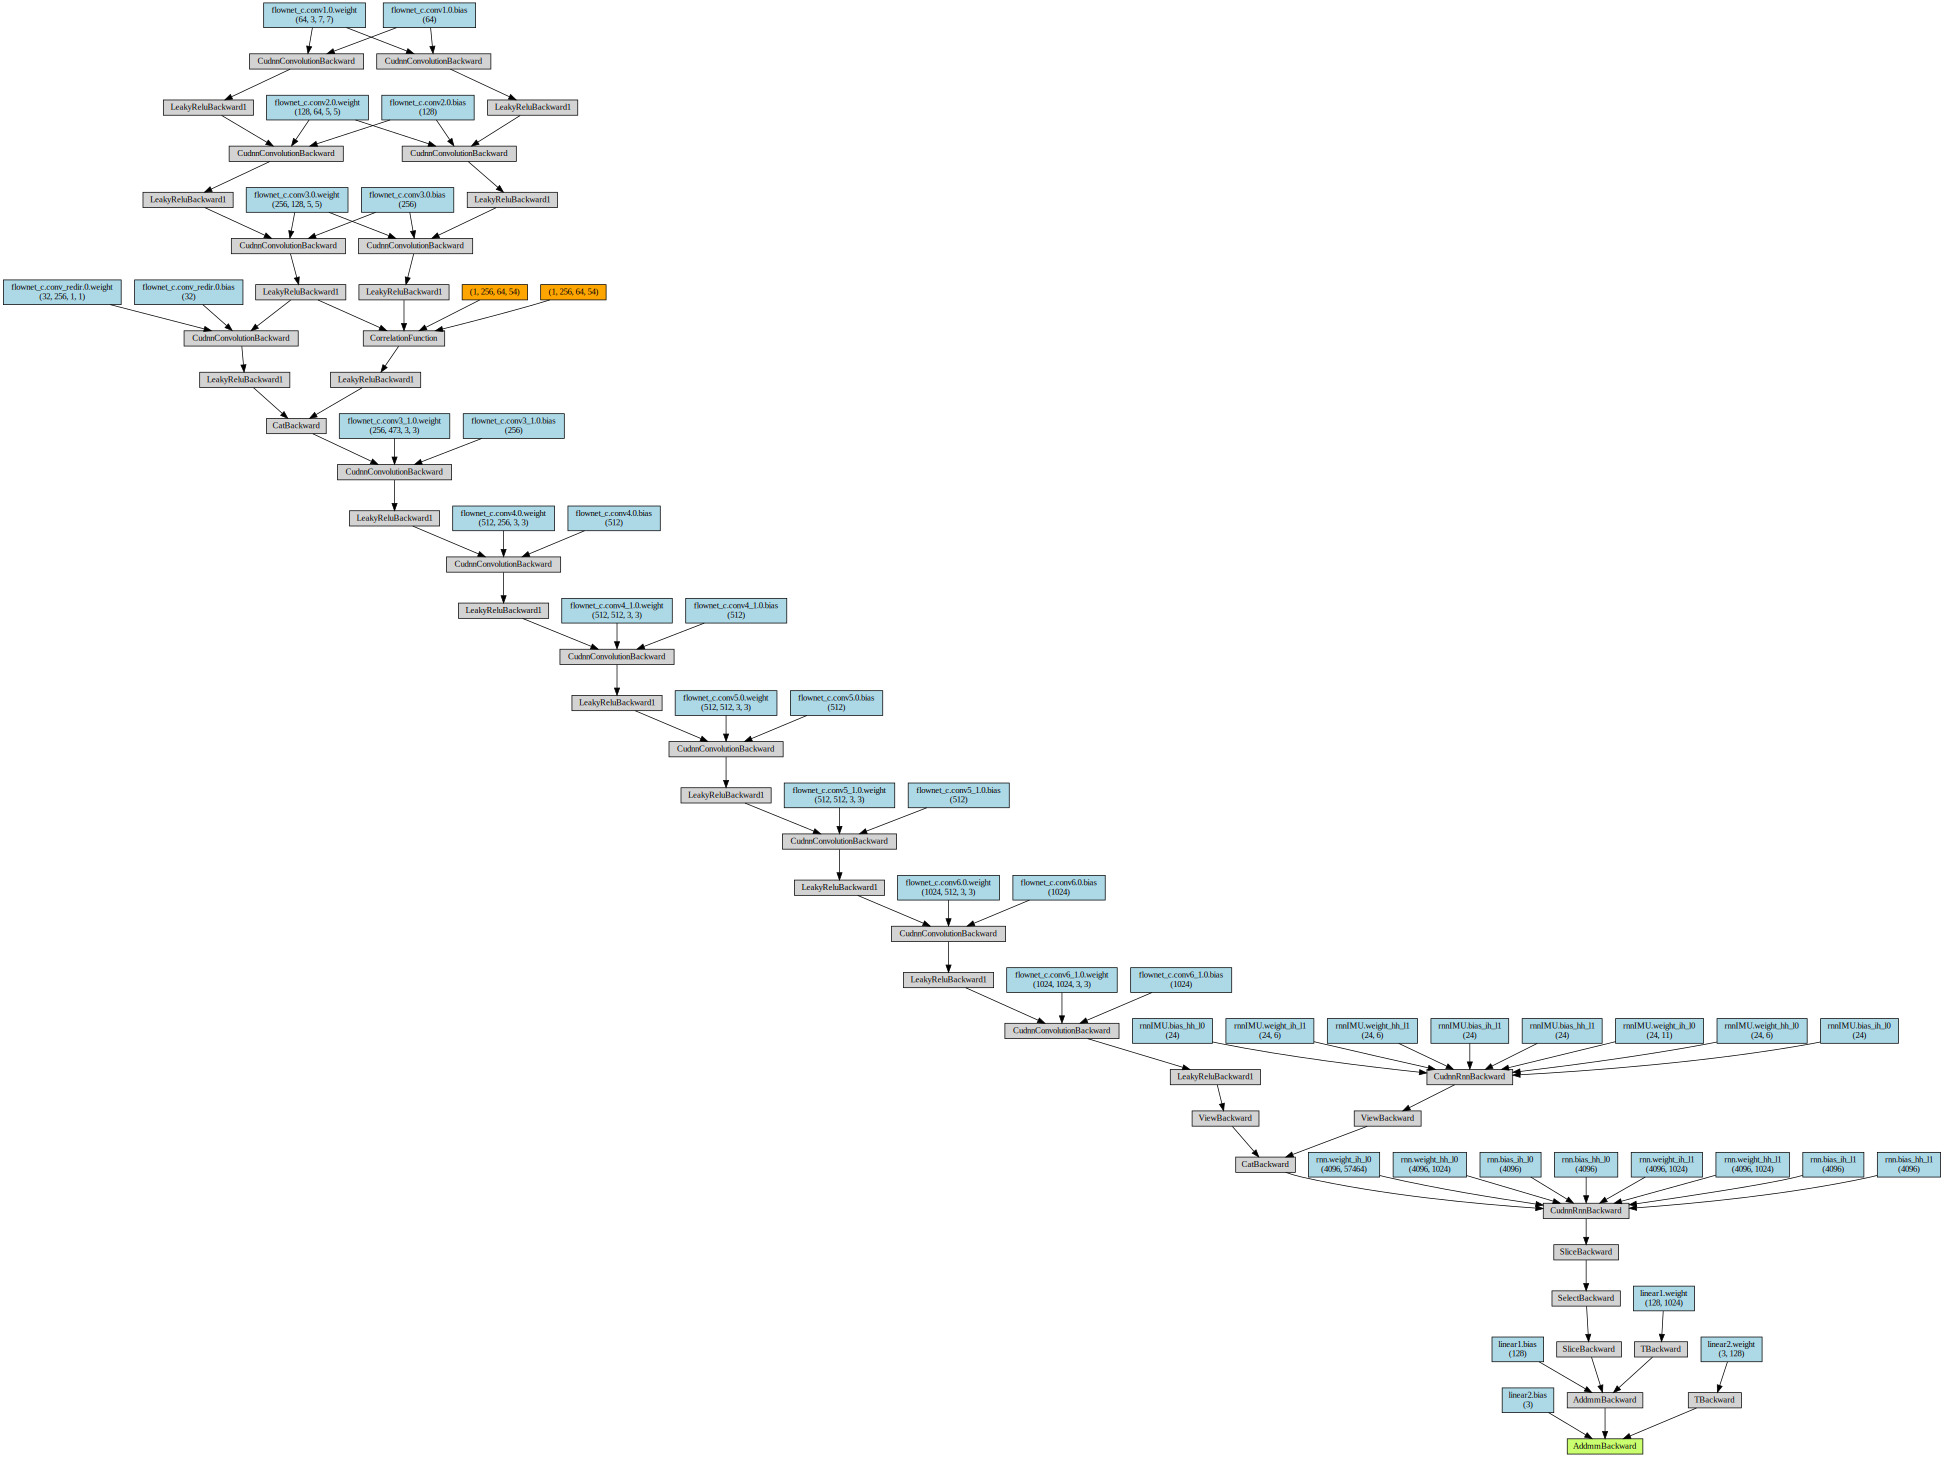

In [114]:
image = X
imu   = X2
y = model(image, imu)
make_dot(y, params = dict(list(model.named_parameters()) + [('x',X)]))

In [45]:
image = torch.randn(1, 2, 3, 384, 1024).requires_grad_(True).cuda()
imu   = torch.randn(10,2,6).requires_grad_(True).cuda()
y = model(image, imu)
make_dot(y, params = dict(list(model.named_parameters()) + [('x',x)]))

torch.Size([1, 1, 98310])


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


RuntimeError: input.size(-1) must be equal to input_size. Expected 49165, got 98310

In [34]:
98310/2

49155.0